In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image
import torch
from torch.autograd import Variable
!pip install hiddenlayer
import hiddenlayer as hl
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
#-- Descomprimimos el dataset
# !rm -r mnist
!unzip "/content/drive/MyDrive/Reto Empresarial/Copy of fashion-mnist.zip"

Streaming output truncated to the last 5000 lines.
  inflating: fashion-mnist/test/0/2423.png  
  inflating: fashion-mnist/test/0/444.png  
  inflating: fashion-mnist/test/0/965.png  
  inflating: fashion-mnist/test/0/1460.png  
  inflating: fashion-mnist/test/0/3440.png  
  inflating: fashion-mnist/test/0/2795.png  
  inflating: fashion-mnist/test/0/2474.png  
  inflating: fashion-mnist/test/0/169.png  
  inflating: fashion-mnist/test/0/1647.png  
  inflating: fashion-mnist/test/0/2121.png  
  inflating: fashion-mnist/test/0/2163.png  
  inflating: fashion-mnist/test/0/2753.png  
  inflating: fashion-mnist/test/0/645.png  
  inflating: fashion-mnist/test/0/34.png  
  inflating: fashion-mnist/test/0/716.png  
  inflating: fashion-mnist/test/0/3874.png  
  inflating: fashion-mnist/test/0/3128.png  
  inflating: fashion-mnist/test/0/2180.png  
  inflating: fashion-mnist/test/0/2439.png  
  inflating: fashion-mnist/test/0/269.png  
  inflating: fashion-mnist/test/0/2027.png  
  inflating:

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
# Rutas de los archivos
train_files = glob('fashion-mnist/train/*/*.png')
valid_files = glob('fashion-mnist/valid/*/*.png')
test_files = glob('fashion-mnist/test/*/*.png')

print('La primera ruta es: ',train_files[0])

# Se vueleven aleatorios los archivos
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

print('Las longitudes son: train {}, valid {}, test {}'.format(len(train_files), len(valid_files), len(test_files)))

# Se cargan las imagenes en las listas
# Datos de entrenamiento
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
    Y_train.append(int(train_file.split('/')[2]))
    X_train.append(np.array(Image.open(train_file)))

# Datos de validación 
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append(int(valid_file.split('/')[2]))
    X_valid.append(np.array(Image.open(valid_file)))

# Datos de prueba
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append(int(test_file.split('/')[2]))
    X_test.append(np.array(Image.open(test_file)))

print('Verificamos las longitudes: Tr {}, V {}, Te {}'.format(len(X_train), len(X_valid), len(X_test)))

def tensor (X,Y):
    X = Variable(torch.from_numpy(np.array(X))).float()
    Y = Variable(torch.from_numpy(np.array(Y))).long()
    return X,Y

def entrena(X_train,Y_train,X_valid,Y_valid,X_test, Y_test,model, optimizer, criterion,train_dl):
    n_epoch = 10

    history2 = hl.History()
    canvas2 = hl.Canvas()

    iter = 0

    for epoch in range(n_epoch):
      for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

        #-- Cargamos los datos en la GPU
        X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

        model.train()
        Xtr = X_train_batch.unsqueeze(1)
        Y_pred = model(Xtr)

        loss = criterion(Y_pred,Y_train_batch)

        Y_pred = torch.argmax(Y_pred, 1)

        #-- Calculamos el f1 en la cpu
        f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

        acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iter += 1

        if iter%10 == 0:
            history2.log((epoch+1, iter), loss=loss, accuracy=acc,f1=f1)
            with canvas2:
              canvas2.draw_plot(history2["loss"])
              canvas2.draw_plot(history2["accuracy"])
              canvas2.draw_plot(history2["f1"])

    CM(Y_train_batch, Y_pred, 10)

def modelo1():
    model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 20, kernel_size=4, stride=2, padding=3),
  #out: ( (28-4+2*3)/2 ) + 1 = 16   -> 16 x 16 x20

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=1),
  #out: 16/1 = 16                 -> 16 x 16 x 20

  torch.nn.Dropout(p=0.2), 

  torch.nn.Conv2d(20, 32, kernel_size=5, stride=1, padding=3),
  #out: ( (16-5+2*3)/1 ) + 1 = 18   -> 18 x 18 x 32

  torch.nn.ReLU(),

  torch.nn.AvgPool2d(kernel_size=2),
  #out: 18/2 = 9                 -> 9 x 9 x 32

  torch.nn.Dropout(p=0.17), 

  torch.nn.Flatten(),
  torch.nn.Linear(9*9*32, 10)
)
    return model
    
def CM(Y_true, Y_pred, classes):
    fig = plt.figure(figsize=(10, 10))
    cm = confusion_matrix(Y_true.detach().cpu().numpy(), Y_pred.detach().cpu().numpy())
    lclasses = np.arange(0,classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap=plt.cm.Blues
    ax = fig.add_subplot(1,1,1)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
    ax.set_xlabel("Predicted",size=20)
    ax.set_ylabel("True",size=20)
    ax.set_ylim(classes-0.5, -0.5)

    plt.setp(ax.get_xticklabels(), size=12)
    plt.setp(ax.get_yticklabels(), size=12)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

    plt.show()


def metodo (X_train, Y_train,X_valid, Y_valid,X_test, Y_test):
    X_train_p, Y_train_p = tensor(X_train, Y_train)
    X_valid_p, Y_valid_p = tensor(X_valid, Y_valid)
    X_test_p, Y_test_p = tensor(X_test, Y_test)
    
    batch_size = 32

    train_ds = torch.utils.data.TensorDataset(X_train_p, Y_train_p)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    model = modelo1()
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

    print('*')
    print('*')
    print('Entrenando el modelo')
    print('*')

    entrena(X_train_p,Y_train_p,X_valid_p,Y_valid_p,X_test_p, Y_test_p,model,optimizer, criterion,train_dl)

    kernels = list(model.children())[0].weight.detach()

    fig = plt.figure(figsize=(16,4))
    k = 0
    for i in range(kernels.size(0)):
        plt.subplot(2,8,k+1)
        plt.imshow(kernels[i].squeeze())
        k += 1
    plt.show()


    X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
    model.eval()
    Xvl = X_valid.unsqueeze(1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

    acc = sum(Y_valid == Y_pred)/len(Y_pred)

    print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )
    print('*')
    print('*')
    print('*')


La primera ruta es:  fashion-mnist/train/8/45081.png
Las longitudes son: train 55000, valid 10000, test 5000
Verificamos las longitudes: Tr 55000, V 10000, Te 5000


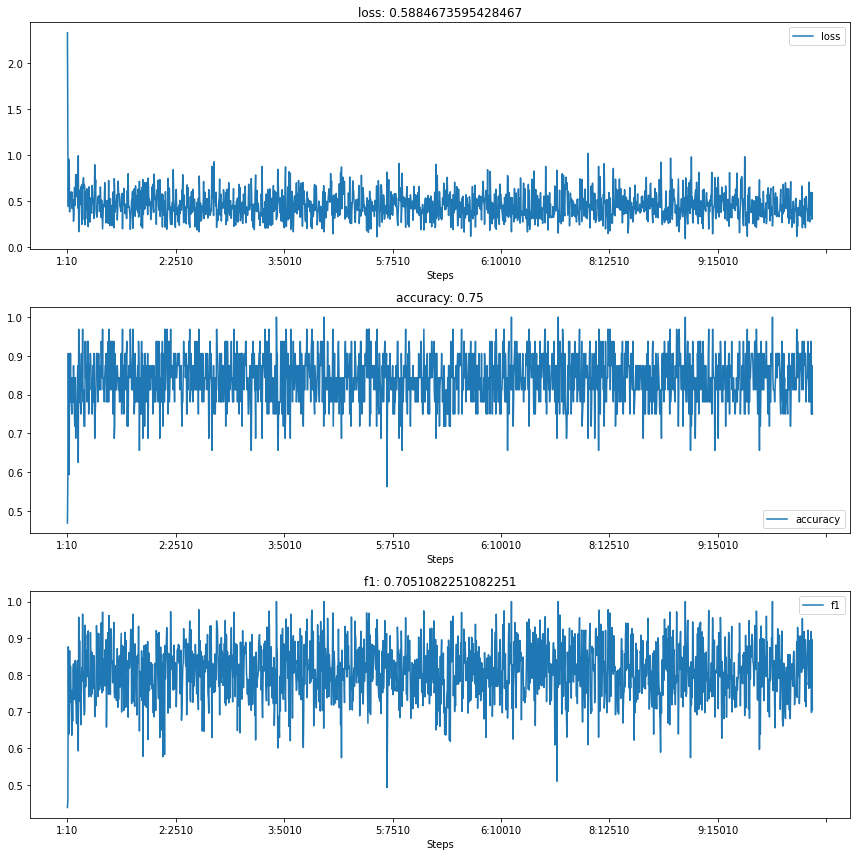

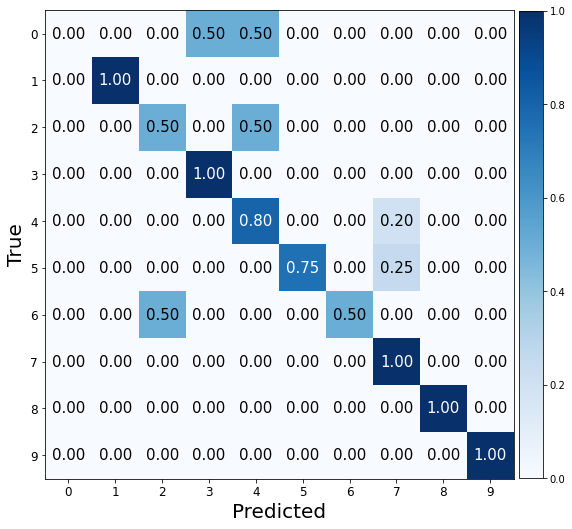

TypeError: ignored

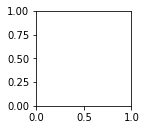

In [16]:
metodo(X_train, Y_train,X_valid, Y_valid,X_test, Y_test)